In [ ]:
!pip install sox
!pip install pydub
!pip install librosa
!pip install pomegranate
!pip install faiss

In [ ]:
import librosa as rosa
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
import numpy as np
import scipy as sp
import scipy.stats as sstats
import pandas as pd
import pomegranate as pg
import pickle
import os
import sys
import pydub
import sox
import datetime
import faiss

from warnings import warn
from tqdm.auto import tqdm


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn import tree
from pomegranate import HiddenMarkovModel
from pomegranate.distributions import DiscreteDistribution
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from scipy.stats import mode

%matplotlib inline

# Preprocessing first method

We will generate short fragments (default 1 second) from audio file which, will be next used to learn models. In this method our samples will be matrices of audio fragments in frequency domain, so by default they whould have shape (22,1024). To transform data from time domain to frequency domain we will use FFT, from `librosa` library. Samples are generated from audio files in wav format. These audios were first preprocessed using `ffmpeg` to have probing frequency 22050 Hz (default value for librosa) and only one channel.
```sh
ffmpeg -i audio1.mp3 -ac 1 -ar 22050 audio1.wav
```
Such preprocessing of audio file `librosa` can make automaticaly, but with our files this requires a lot of RAM (more than 8GB) and preprocessing using `ffmpeg` does not have such a problem.

Preprocessing be default is looking for audio files in `data` directory and save generated dataset to `dataset` directory. Additionaly it creates `subfragments` and `sortedSubfragments` directories to save auxilliary datas to use less RAM.

Probing frequency is default for `librosa` library and it is sufficient to process audio files, because human can hear waves with frequencies between 20Hz and 20000 Hz, but we hear best in range 1kHz-3kHz and most music instrument has wave frequenciess less than 4400Hz [(see: Skale instrumentów muzycznych)](https://pl.wikipedia.org/wiki/Skale_instrument%C3%B3w_muzycznych). Based on Nyquista–Shannona theorem [(see: Twierdzenie o próbkowaniu)](https://pl.wikipedia.org/wiki/Twierdzenie_o_pr%C3%B3bkowaniu) we can reconstruct wave with frequency $f$ without errors if we probe it with freqency biger or equal to $2*f$, so using probing frequency 22050 Hz we can reconstruct waves with frequencies of 11025 Hz, so it is much bigger frequency than most instruments can emit.

Having preprocessed files we load them into python script and split into fragment according to labels. Next from each fragment we randomly generate subfragments which will be used in learning. Each subfragment is processed by FFT and from this result is taking absolute value (amplitude).
$$
S_N=\frac{L}{S}*ratio
$$
$S_N$ - number of subfragments generated from fragment $F$

$L$ - length of fragment $F$ in seconds

$S$ - length of subfragmentt in seconds

$ratio$ - constant (default $0.5$)

After generating subfragments, data sets where created. When $P$ is vector of probablities of drawing subfragment of diffrent types. Then $N$ numbers was drawn from distribution $P$, where $N$ is number of samples which should be in dataset and for each type $T$ drawn from $P$ one subfrgament of type $T$ was drawn.

Vector $P$ has subsequent probabilities:

music - $0.5$

clean speech - $0.25$

phone call - $0.125$

speech with music in background - $0.125$

So using these techniques, we got shuffled, random generated, dataprobes to use in learning of clasification models. But our second step, this is HMM, is time aware, so it need unshuffled data. So we generated second dataset of data which will be used to learn HMM and these data are sorted according in order of apperence in dataset. Additionaly data for HMM aren't sampled instead of that there contain there contain maximal number of subfragments, which can be generated in each fragment. This is because of time-awareness of HMM, so HMM to learn properly should know ratio of different kinds of data types in dataset and their order in time.
Based on our data we generated train set for HMM which contains $\frac{2}{3}$ of our data and rest data created test set.

In [6]:
dataDirPath="../data/"
namesMainParts=["1","2","3"]
audioFilePrefix="audio"
audioFileSufix=".wav"
labelFilePrefix="labels"
labelFileSufix=".txt"

In [7]:
subfragmentsDir="../subfragments/"
sortedSubfragmentsDir="../sortedSubfragments/"
subfragmentLengthInSeconds=1
# ratio used to calculate muber of subfragments to generate from fragment
# if L is length of fragment in second, S length of subfragment in seconds
# then from this subfragment will be generated L/S*subfragToFragLengthRatio+1 subfragments
subfragToFragLengthRatio=0.5

In [8]:
typeList=["m","s","j","sm","pc"]

In [9]:
os.makedirs(sortedSubfragmentsDir, exist_ok=True)
for typ in typeList:
    os.makedirs(sortedSubfragmentsDir+typ, exist_ok=True)

In [20]:
datasetDir="../dataset/"
os.makedirs(datasetDir, exist_ok=True)

## Label Parsing

In [10]:
def parseLabelFile(pathToFile):
    startsOfFragments={"m":[], "s":[], "j":[], "sm":[], "pc":[]}
    with open(pathToFile, "r") as labelFile:
        labelFile.readline()
        for line in labelFile:
            line=line[:-1]
            listedLine=line.split(",")
            if listedLine[-1]=="":
                listedLine=listedLine[:-1]
            timestamp=listedLine[0].split(":")
            timeInSeconds=int(timestamp[-1])+int(timestamp[-2])*60+int(timestamp[-3])*3600
            if listedLine[1]=="silence":
                continue
            elif listedLine[1]=="music":
                if len(listedLine)>2:
                    if listedLine[2]=="jingle":
                        startsOfFragments["j"].append(timeInSeconds)
                        continue
                    else:
                        warn(RuntimeWarning("Second argument isn't recognized: "+listedLine[2]))
                startsOfFragments["m"].append(timeInSeconds)
            elif listedLine[1]=="speech":
                if len(listedLine)>2:
                    if listedLine[2]=="musicinthebackground":
                        startsOfFragments["sm"].append(timeInSeconds)
                        continue
                    elif listedLine[2]=="phonecall":
                        startsOfFragments["pc"].append(timeInSeconds)
                        continue
                    else:
                        warn(RuntimeWarning("Second argument isn't recognized: "+listedLine[2]))
                startsOfFragments['s'].append(timeInSeconds)
            else:
                warn(RuntimeWarning("Type argument isn't recognized: "+listedLine[1]))
    return startsOfFragments

In [11]:
class AudioFragment:
    def __init__(self, typ, audio, startPointInSec, fileName,sr):
        self.typ=typ
        self.audio=audio
        self.startPoint=startPointInSec
        self.fileName=fileName
        self.sr=sr
    def drawSubfragment(self, lengthInSeconds):
        lengthInProbes=self.sr*lengthInSeconds
        if len(self.audio)<lengthInProbes:
            raise RuntimeError("Fragment is to short to generate requested length.")
        index=np.random.randint(0,len(self.audio)-lengthInProbes+1)
        return self.audio[index:index+lengthInProbes].copy()
    def getLengthInSeconds(self):
        return len(self.audio)/self.sr

In [12]:
class SubfragmentIndex:
    def __init__(self):
        self.numberOfSubfragments=0
        self.subfragmentsByType={"m":[], "s":[], "j":[], "sm":[], "pc":[]}
    def getNextNumberOfSubfragment(self):
        return self.numberOfSubfragments+1
    def addNewSubfragmentToIndex(self, subfragmentPath, subfragmentTyp):
        self.numberOfSubfragments+=1
        self.subfragmentsByType[subfragmentTyp].append(subfragmentPath)
        return
    def drawRandomSubfragment(self):
        r=np.random.randint(0, self.numberOfSubfragments)
        for typ in self.subfragmentsByType:
            if r>len(self.subfragmentsByType[typ]):
                r-=len(self.subfragmentsByType[typ])
            else:
                return self.subfragmentsByType[typ][r]
        raise RuntimeError("Something went wrong")
    def drawRandomByType(self, typ):
        r=np.random.randint(0, len(self.subfragmentsByType[typ]))
        return self.subfragmentsByType[typ][r]

In [13]:
def generateSubfragments():
    subfInd=SubfragmentIndex()
    for name in namesMainParts:
        audioFilePath=dataDirPath+audioFilePrefix+name+audioFileSufix
        labelFilePath=dataDirPath+labelFilePrefix+name+labelFileSufix
        audio, sr=rosa.load(audioFilePath)
        if (sr!=22050):
            warn("Sapling rate of file: "+audioFilePath+" is diffrent than 22050.")
        startOfFragmentsDict=parseLabelFile(labelFilePath)

        sortedListOfStarts=[]
        for typ in startOfFragmentsDict:
            sortedListOfStarts.extend(startOfFragmentsDict[typ])
        sortedListOfStarts.sort()

        for typ in startOfFragmentsDict:
            for start in startOfFragmentsDict[typ]:
                index=sortedListOfStarts.index(start)
                if index+1==len(sortedListOfStarts):
                    end=int(len(audio)/sr)
                else:
                    end=sortedListOfStarts[index+1]
                af=(AudioFragment(typ, audio[start*sr:end*sr], start, audioFilePath, sr))
                numberOfSubfragmentsToGenerate=int(af.getLengthInSeconds()/subfragmentLengthInSeconds*\
                    subfragToFragLengthRatio+1)
                try:
                    for i in range(numberOfSubfragmentsToGenerate):
                        subfragment=af.drawSubfragment(subfragmentLengthInSeconds)
                        subfragmentFFT=np.abs(rosa.stft(subfragment, hop_length=1024))
                        picklePath=subfragmentsDir+typ+"/"+str(subfInd.getNextNumberOfSubfragment())+".pickle"
                        with open(picklePath,"wb") as pickleFile:
                            pickle.dump(subfragmentFFT, pickleFile)
                        subfInd.addNewSubfragmentToIndex(picklePath, typ)
                except RuntimeError:
                    pass
    return subfInd

In [14]:
def generateSubfragmentsSorted():
    subfInd=SubfragmentIndex()
    listOfPaths=[]
    for name in namesMainParts:
        audioFilePath=dataDirPath+audioFilePrefix+name+audioFileSufix
        labelFilePath=dataDirPath+labelFilePrefix+name+labelFileSufix
        audio, sr=rosa.load(audioFilePath)
        if (sr!=22050):
            warn("Sapling rate of file: "+audioFilePath+" is diffrent than 22050.")
        startOfFragmentsDict=parseLabelFile(labelFilePath)

        sortedListOfStarts=[]
        for typ in startOfFragmentsDict:
            sortedListOfStarts.extend(startOfFragmentsDict[typ])
        sortedListOfStarts.sort()

        for typ in startOfFragmentsDict:
            for start in startOfFragmentsDict[typ]:
                index=sortedListOfStarts.index(start)
                if index+1==len(sortedListOfStarts):
                    end=int(len(audio)/sr)
                else:
                    end=sortedListOfStarts[index+1]
                af=(AudioFragment(typ, audio[start*sr:end*sr], start, audioFilePath, sr))
                                
                for i in range(0, int(af.getLengthInSeconds()-2*subfragmentLengthInSeconds), 
                               subfragmentLengthInSeconds):
                    subfragment=af.audio[i*af.sr : (i+subfragmentLengthInSeconds)*af.sr]
                    subfragmentFFT=np.abs(rosa.stft(subfragment, hop_length=1024))
                    picklePath=sortedSubfragmentsDir+typ+"/"+str(subfInd.getNextNumberOfSubfragment())+".pickle"
                    with open(picklePath,"wb") as pickleFile:
                        pickle.dump(subfragmentFFT, pickleFile)
                    subfInd.addNewSubfragmentToIndex(picklePath, typ)
                    listOfPaths.append(picklePath)
    return subfInd, listOfPaths

In [15]:
SI=generateSubfragments()

In [16]:
SSI, listOfPaths=generateSubfragmentsSorted()

## Creating Testsets for predictor

In [17]:
def createTestSet(subfragIndex, testSetSize, typeWeights, savePath):
    for typ in typeWeights:
        expectedNumber=typeWeights[typ]*testSetSize
        if len(subfragIndex.subfragmentsByType[typ])<expectedNumber:
            warn("There is less subfragments for type: "+typ+" than expected number of samples in dataset.")
    randomTypes=np.random.choice(len(typeWeights.keys()),size=testSetSize, p=list(typeWeights.values()))
    keys=list(typeWeights.keys())
    
    dataList=[]
    labelList=[]
    for randomTyp in randomTypes:
        typ=keys[randomTyp]
        randSubfPath=subfragIndex.drawRandomByType(typ)
        with open(randSubfPath, "rb") as pickleFile:
            dataList.append(pickle.load(pickleFile))
            labelList.append(typ)
    with open(savePath, "wb") as pickleFile:
        pickle.dump((dataList, labelList), pickleFile)

In [18]:
def generateTestsSets(numberOfSets, sizes):
    for s in sizes:
        for i in range(numberOfSets):
            createTestSet(SI, s, {"m":0.5, "s":0.25, "j":0, "sm":0.125, "pc":0.125}, 
                          datasetDir+"dataset{}-{}.pickle".format(s,i))

In [21]:
generateTestsSets(3, [1000])

## Creating Testsets for HMM

In [24]:
testSetSize=int(len(listOfPaths)/3)
trainSetSize=len(listOfPaths)-testSetSize

trainDataList=[]
trainLabelList=[]
for i in range(trainSetSize):
    path=listOfPaths[i]
    typeOfPath=path.split("/")[2]
    trainLabelList.append(typeOfPath)
    with open(path, "rb") as pickleFile:
        trainDataList.append(pickle.load(pickleFile))

testDataList=[]
testLabelList=[]
for i in range(testSetSize):
    path=listOfPaths[i+trainSetSize]
    typeOfPath=path.split("/")[2]
    testLabelList.append(typeOfPath)
    with open(path, "rb") as pickleFile:
        testDataList.append(pickle.load(pickleFile))   

# Preprocessing second method

The other approach for the preprocessing that we tried is to calculate some statistics for each second of the recordings. To do that we used functions from the `feature` module available in `librosa` library. We calculated and averaged such things like:
* chromagram
* root mean square
* spectral centroid
* spectral bandwidth
* spectral rolloff
* zero crossing rate
* Mel - frequency spectral coefficients (MFCCs)

In the end we obtain data frame with dimensions (total duration of recordings in seconds) x 27. One of our goals is to compare the impact of preprocessing approaches on performence of classifiers.

In [5]:
REPO_DIR = sys.path[0]+"/../"
AUDIO_TYPE = ".wav"
SECOND = 1000

In [45]:
os.chdir(REPO_DIR)
os.listdir(REPO_DIR + "/data")
for i in [1, 2, 3]:
    os.makedirs(REPO_DIR + "/data/audio{}".format(i), exist_ok=True)

## Audio1

In [46]:
audio = pydub.AudioSegment.from_wav(REPO_DIR + "data/audio1.wav")
new_audio = [audio[i * SECOND : (i + 1) * SECOND] for i in range(len(audio)//SECOND)]
for fragment in enumerate(new_audio):
    fragment[1].export("data/audio1/audio1_{}.wav".format(fragment[0] + 1), format="wav")
labels_df = pd.read_csv('data/labels1.txt')[['timestamp', 'label']]
labels_df['timestamp'] = labels_df['timestamp'].apply(lambda x: datetime.datetime.strptime(x, "%H:%M:%S"))
labels_df = labels_df.set_index('timestamp')
labels_df = labels_df.resample('1S').pad()
labels_df['seconds'] = labels_df.index
labels_df['seconds'] = labels_df['seconds'].apply(lambda x: int((x - datetime.datetime(1900, 1, 1)).total_seconds()))
labels_df.to_csv(REPO_DIR + '/data/labels1_long.csv', index=False)

In [ ]:
rows = []
for second in tqdm(labels_df['seconds']):
    y, sr = librosa.load(REPO_DIR + "data/audio1/audio1_{}.wav".format(second))
    label = labels_df[labels_df['seconds'] == second]['label'][0]
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    rmse = np.mean(librosa.feature.rms(y=y))
    spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    mfccs = []
    for e in mfcc:
        mfccs.append(np.mean(e))
    obs = [second, label, rmse, chroma_stft, spec_cent, spec_bw, rolloff, zcr]
    obs.extend(mfccs)
    rows.append(obs)

In [48]:
columns = ['timestamp', 'label', 'chroma_stft', 'rmse', 'spec_cent', 'spec_bw', 'rolloff', 'zcr']
columns.extend(['mfcc_{}'.format(i) for i in range(len(mfcc))])
data = pd.DataFrame(rows, columns = columns)
data.head()
data.to_csv(REPO_DIR + "/data/data_1.csv")

## Audio2

In [49]:
audio = pydub.AudioSegment.from_wav(REPO_DIR + "data/audio2.wav")

In [50]:
new_audio = [audio[i * SECOND : (i + 1) * SECOND] for i in range(len(audio)//SECOND)]

In [51]:
for fragment in enumerate(new_audio):
    fragment[1].export("data/audio2/audio2_{}.wav".format(fragment[0] + 1), format="wav")

In [52]:
labels_df = pd.read_csv('data/labels2.txt')[['timestamp', 'label']]
labels_df['timestamp'] = labels_df['timestamp'].apply(lambda x: datetime.datetime.strptime(x, "%H:%M:%S"))
labels_df = labels_df.set_index('timestamp')
labels_df = labels_df.resample('1S').pad()
labels_df['seconds'] = labels_df.index
labels_df['seconds'] = labels_df['seconds'].apply(lambda x: int((x - datetime.datetime(1900, 1, 1)).total_seconds()))
labels_df.to_csv(REPO_DIR + '/data/labels2_long.csv', index=False)

In [ ]:
rows = []
for second in tqdm(labels_df['seconds']):
    y, sr = librosa.load(REPO_DIR + "data/audio2/audio2_{}.wav".format(second))
    label = labels_df[labels_df['seconds'] == second]['label'][0]
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    rmse = np.mean(librosa.feature.rms(y=y))
    spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    mfccs = []
    for e in mfcc:
        mfccs.append(np.mean(e))
    obs = [second, label, rmse, chroma_stft, spec_cent, spec_bw, rolloff, zcr]
    obs.extend(mfccs)
    rows.append(obs)

In [54]:
columns = ['timestamp', 'label', 'chroma_stft', 'rmse', 'spec_cent', 'spec_bw', 'rolloff', 'zcr']
columns.extend(['mfcc_{}'.format(i) for i in range(len(mfcc))])
data = pd.DataFrame(rows, columns = columns)
data.head()
data.to_csv(REPO_DIR + "/data/data_2.csv")

## Audio3

In [55]:
audio = pydub.AudioSegment.from_wav(REPO_DIR + "data/audio3.wav")

In [56]:
new_audio = [audio[i * SECOND : (i + 1) * SECOND] for i in range(len(audio)//SECOND)]

In [57]:
for fragment in enumerate(new_audio):
    fragment[1].export("data/audio3/audio3_{}.wav".format(fragment[0] + 1), format="wav")

In [58]:
labels_df = pd.read_csv('data/labels3.txt')[['timestamp', 'label']]
labels_df['timestamp'] = labels_df['timestamp'].apply(lambda x: datetime.datetime.strptime(x, "%H:%M:%S"))
labels_df = labels_df.set_index('timestamp')
labels_df = labels_df.resample('1S').pad()
labels_df['seconds'] = labels_df.index
labels_df['seconds'] = labels_df['seconds'].apply(lambda x: int((x - datetime.datetime(1900, 1, 1)).total_seconds()))
labels_df.to_csv(REPO_DIR + '/data/labels3_long.csv', index=False)

In [ ]:
rows = []
for second in tqdm(labels_df['seconds']):
    y, sr = librosa.load(REPO_DIR + "data/audio3/audio3_{}.wav".format(second))
    label = labels_df[labels_df['seconds'] == second]['label'][0]
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    rmse = np.mean(librosa.feature.rms(y=y))
    spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    mfccs = []
    for e in mfcc:
        mfccs.append(np.mean(e))
    obs = [second, label, rmse, chroma_stft, spec_cent, spec_bw, rolloff, zcr]
    obs.extend(mfccs)
    rows.append(obs)

In [60]:
columns = ['timestamp', 'label', 'chroma_stft', 'rmse', 'spec_cent', 'spec_bw', 'rolloff', 'zcr']
columns.extend(['mfcc_{}'.format(i) for i in range(len(mfcc))])
data = pd.DataFrame(rows, columns = columns)
data.head()
data.to_csv(REPO_DIR + "/data/data_3.csv")

# Visualization of the data with TSNE

Below we can take a look at the plot of the data transformed with TSNE algorithm to 2D space. We can notice that the speech and music are separable in such way that music is an outside layer of the crescent created by the observations of speech.

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

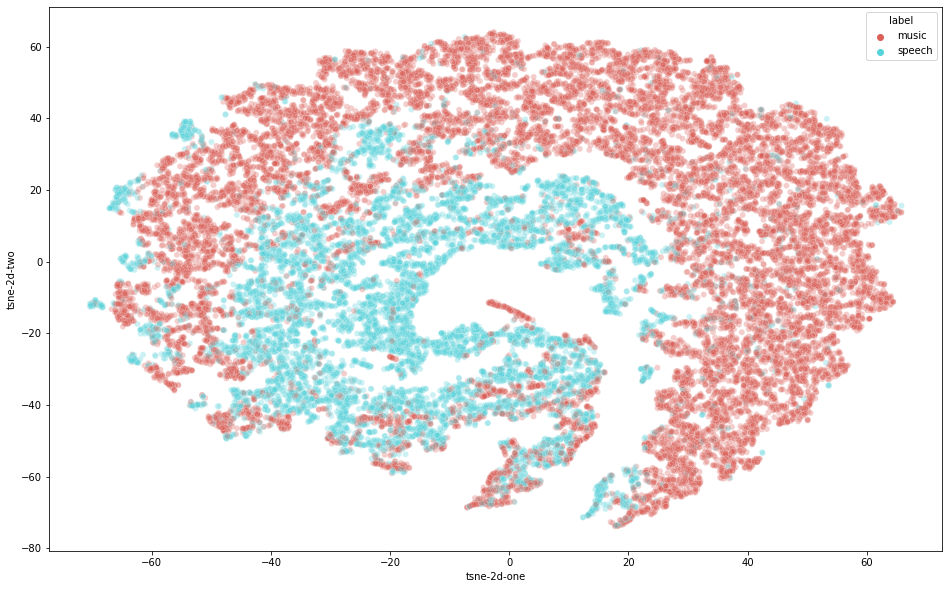

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
import numpy as np
from time import time
import pickle

data = pd.concat([pd.read_csv(REPO_DIR + "/data/data_{}.csv".format(i), index_col=False) for i in [1, 2, 3]])

data.drop('Unnamed: 0', axis=1, inplace=True)
data.drop('timestamp', axis=1, inplace=True)

X = data.drop('label', axis = 1)
y = data['label']

tsne = TSNE(n_components=2, init='random', random_state=0, perplexity = 50, learning_rate = 200)
X_tsne = tsne.fit_transform(X)

data['tsne-2d-one'] = X_tsne[:,0]
data['tsne-2d-two'] = X_tsne[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 2),
    data=data,
    legend="full",
    alpha=0.3
)

# Class Spectograms

Below we can take a look at couple of samples from the first preprocessing approach, we can think of this approach as transferring problem of audio classification to image classification.

In [116]:
with open('../data/dataset/dataset1000-0.pickle', 'rb') as f:
    dataset = pickle.load(f)

pc


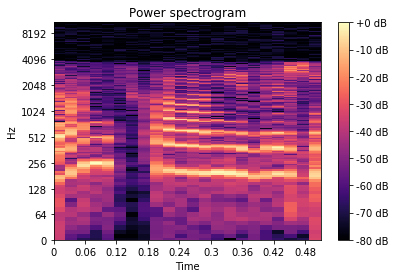

In [117]:
k = 3
exampleSpectrogram = dataset[0][k]
exampleLabel = dataset[1][k]
print(exampleLabel)
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(exampleSpectrogram,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

m


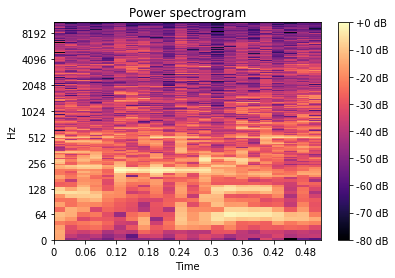

In [118]:
k = 13
exampleSpectrogram = dataset[0][k]
exampleLabel = dataset[1][k]
print(exampleLabel)
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(exampleSpectrogram,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

s


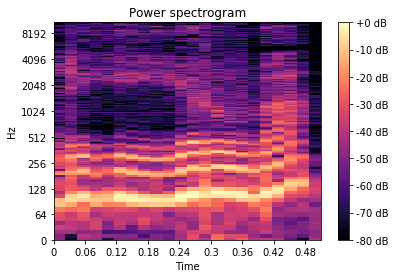

In [119]:
k = 7
exampleSpectrogram = dataset[0][k]
exampleLabel = dataset[1][k]
print(exampleLabel)
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(exampleSpectrogram,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

sm


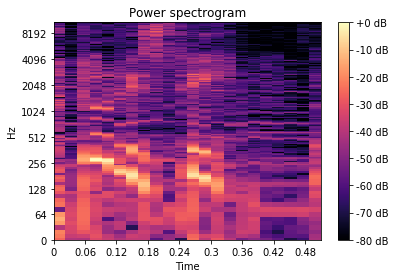

In [120]:
k = 1
exampleSpectrogram = dataset[0][k]
exampleLabel = dataset[1][k]
print(exampleLabel)
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(exampleSpectrogram,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

Differences between spectrograms are quite significant so we may expect that the models that we are going to use will be able to cope with the problem of classification.

# Learning & Evaluation - Supervised - Preprocessing 1

In [4]:
with open(sys.path[0]+'/data/dataset1000-0.pickle', 'rb') as f:
    dataset_1 = pickle.load(f)
    
with open(sys.path[0]+'/data/dataset1000-1.pickle', 'rb') as f:
    dataset_2 = pickle.load(f)

In [9]:
def transformLabels(dataset):
    labels = []
    for label in dataset[1]:
        if label=='pc' or label=='sm':
            labels.append('s')
        elif label=='j':
            labels.append('m')
        else:
            labels.append(label)

    return labels

In [19]:
labels=transformLabels([dataset_1, dataset_2, dataset_3])

In [15]:
data= np.stack([dataset_1[0], dataset_2[0], dataset_3[0]])

In [21]:
trainX, testX, trainY, testY = train_test_split(np.array(data), np.array(labels), test_size = 0.2, random_state=42, stratify=labels)

## K-nearest neighbors

In [22]:
ks = np.arange(2,51,4)

results = []

for k in tqdm(ks):
    knnClf = KNeighborsClassifier(n_neighbors=k)
    knnClf.fit(trainX.astype('float32').reshape(-1, 1025*22), trainY)
    trainPreds = knnClf.predict(trainX.astype('float32').reshape(-1, 1025*22))
    testPreds = knnClf.predict(testX.astype('float32').reshape(-1, 1025*22))
    
    results.append({'ks': k, 'set': 'train', 'score': accuracy_score(y_true=trainY, y_pred=trainPreds)})
    results.append({'ks': k, 'set': 'test', 'score': accuracy_score(y_true=testY, y_pred=testPreds)})
    
results = pd.DataFrame(results)

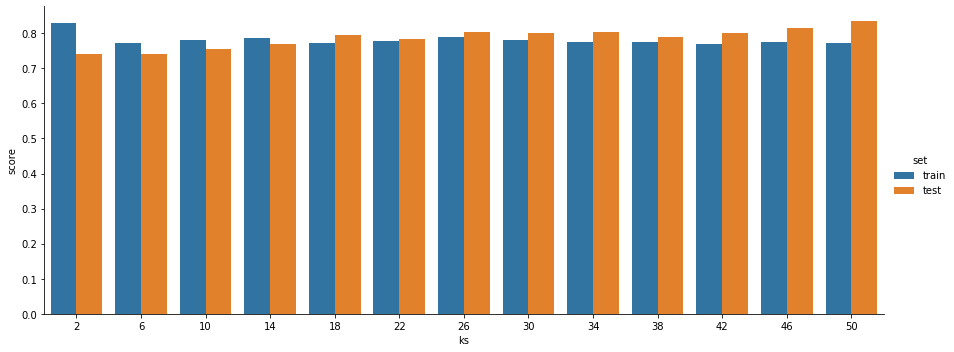

In [23]:
sns.catplot(x = 'ks', y = 'score', hue='set', data=results, kind = 'bar', aspect=2.5)

In [28]:
best_ks = ks[np.argsort(results.loc[(results['set'] == 'test')]['score'])[::-1]][0]
print('Best k: {} with Test Accuracy = {:.4f}'.format(best_ks, 
                                                      np.array(results.loc[(results['set'] == 'test') & 
                                                                  (results['ks'] == best_ks)]['score'])[0]))
knnClf = KNeighborsClassifier(n_neighbors=best_ks)
knnClf.fit(trainX.reshape(-1,1025*22), trainY)

Best k: 50 with Test Accuracy = 0.8350


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')

## RandomForestClassifier

In [7]:
depths = np.arange(5,51,5)
results = []
    
for depth in tqdm(depths): 
    rfClf = RandomForestClassifier(max_depth=depth, random_state=0)
    rfClf.fit(trainX.reshape(-1,1025*22), trainY)
    trainPreds = rfClf.predict(trainX.reshape(-1,1025*22))
    testPreds = rfClf.predict(testX.reshape(-1,1025*22))

    results.append({'depth': depth, 'set': 'train', 'score': accuracy_score(y_true=trainY, y_pred=trainPreds)})
    results.append({'depth': depth, 'set': 'test', 'score': accuracy_score(y_true=testY, y_pred=testPreds)})
    
results = pd.DataFrame(results)

  0%|          | 0/10 [00:00<?, ?it/s]

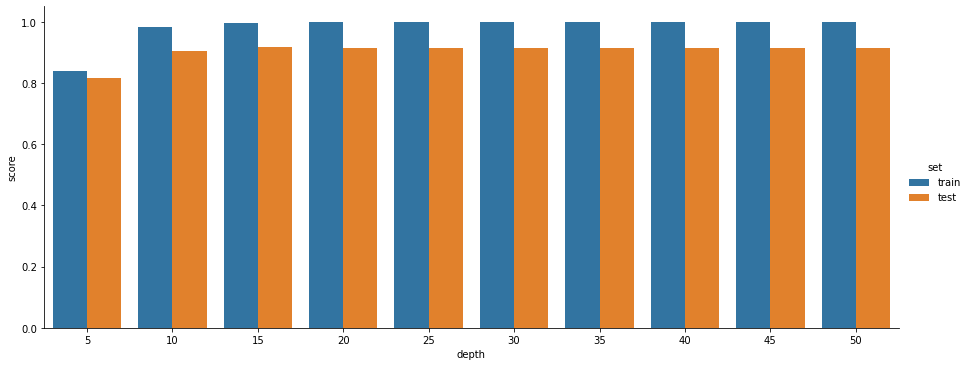

In [8]:
sns.catplot(x = 'depth', y = 'score', hue='set', data=results, kind = 'bar', aspect=2.5)

In [9]:
best_depth = depths[np.argsort(results.loc[(results['set'] == 'test')]['score'])[::-1]][0]
print('Best depth: {} with Test Accuracy = {:.4f}'.format(best_depth, 
                                                      np.array(results.loc[(results['set'] == 'test') & 
                                                                  (results['depth'] == best_depth)]['score'])[0]))
rfClf = RandomForestClassifier(max_depth=best_depth, random_state=0)
rfClf.fit(trainX.reshape(-1,1025*22), trainY)

Best depth: 15 with Test Accuracy = 0.9183


RandomForestClassifier(max_depth=15, random_state=0)

## Smoothing with HMM

In [10]:
with open(sys.path[0]+'/../dataset/HMM-dataset-train.pickle', 'rb') as f:
    train_dataset = pickle.load(f)
    
with open(sys.path[0]+'/../dataset/HMM-dataset-test.pickle', 'rb') as f:
    test_dataset = pickle.load(f)

In [11]:
train_X = np.concatenate([np.stack(train_dataset[0]).reshape(-1, 1025*22)])

train_y = np.concatenate([np.stack(train_dataset[1])])

test_X = np.stack(test_dataset[0]).reshape(-1, 1025*22)
test_y = np.stack(test_dataset[1])

del train_dataset
del test_dataset

In [12]:
class smoothHMM:

    def __init__(self, predictor, state_names):

        self.predictor = predictor
        self.modelHMM = HiddenMarkovModel()
        self.le=LabelEncoder()
        self.state_names = state_names

    def fit(self, X, y):
        
        X_prediction=self.predictor.predict(X)
        for i in range(len(X_prediction)):
            if X_prediction[i]=='pc' or X_prediction[i]=='sm':
                X_prediction[i]='s'
        X_simplified = self.le.fit_transform(X_prediction).reshape(1, -1)
        
        print(np.unique(X_simplified))
        for i in range(len(y)):
            if y[i]=='pc' or y[i]=='sm':
                y[i]='s'
            if y[i]=='j':
                y[i]='m'
                
        y = y.reshape(1, -1)

        
        print(np.unique(y))
        
        self.modelHMM = self.modelHMM.from_samples(DiscreteDistribution, 2, X_simplified, labels = y,
                                   algorithm='labeled', state_names=['m','s'], verbose = True)
        self.modelHMM.bake()
           

    def predict(self, X):
        X_prediction=self.predictor.predict(X)
        for i in range(len(X_prediction)):
            if X_prediction[i]=='pc' or X_prediction[i]=='sm':
                X_prediction[i]='s'
        X_simplified = self.le.transform(X_prediction).tolist()
        
        return self.modelHMM.predict(X_simplified)
    
    def score(self, X, y):
        
        target = self.predict(X)
        
        for i in range(len(y)):
            if y[i]=='pc' or y[i]=='sm':
                y[i]='s'
            if y[i]=='j':
                y[i]='m'
                
        y = self.le.transform(y)
        
        return np.sum(target==y)/y.shape[0]

In [13]:
hmm = smoothHMM(knnClf state_names=['m', 'pc', 's', 'sm'])
hmm.fit(train_X, train_y)

[0 1]
['m' 's']
[1] Improvement: 8482.455102094127	Time (s): 0.03402
[2] Improvement: 0.0	Time (s): 0.03538
Total Training Improvement: 8482.455102094127
Total Training Time (s): 0.1047


In [14]:
hmm.score(test_X, test_y)

0.883678254664084

In [16]:
hmm = smoothHMM(rfClf, state_names=['m', 'pc', 's', 'sm'])
hmm.fit(train_X, train_y)

[0 1]
['m' 's']
[1] Improvement: 2167.2647784450164	Time (s): 0.03367
[2] Improvement: 0.0	Time (s): 0.03449
Total Training Improvement: 2167.2647784450164
Total Training Time (s): 0.1028


In [17]:
hmm.score(test_X, test_y)

0.9716586808033438

# Learning & Evaluation - Supervised - Preprocessing 2

In [5]:
REPO_DIR = sys.path[0]+"/"
data = pd.concat([pd.read_csv(REPO_DIR + "/data/data_{}.csv".format(i), index_col=False) for i in [1,2]])
data.drop('Unnamed: 0', axis=1, inplace=True)
data.drop('timestamp', axis=1, inplace=True)

In [6]:
data.head()

,label,chroma_stft,rmse,spec_cent,spec_bw,rolloff,zcr,mfcc_0,mfcc_1,mfcc_2,...,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19
0,music,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-1131.370972,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,music,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-1131.370972,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,music,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-1131.370972,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,music,0.012444,0.081449,432.529692,424.989395,949.418501,0.01466,-632.946411,12.773681,-1.715082,...,-2.038454,-0.884550,-1.802255,0.243648,-0.727257,0.287844,0.141726,-0.364878,-0.763656,-0.566740
4,music,0.172535,0.435161,2309.434221,2392.904163,4963.403320,0.10235,-33.924923,96.108818,-15.746825,...,-10.182379,-11.484722,-13.531470,-5.707917,-9.890487,-1.513985,-8.121307,-4.673933,-4.060278,-2.206214


In [7]:
X = data.drop('label', axis=1)
y = data['label']

trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)

## RandomForestClassifier

In [ ]:
depths = np.arange(5,51,5)
results = []
    
for depth in tqdm(depths): 
    rfClf = RandomForestClassifier(max_depth=depth, random_state=0)
    rfClf.fit(trainX, trainY)
    trainPreds = rfClf.predict(trainX)
    testPreds = rfClf.predict(testX)

    results.append({'depth': depth, 'set': 'train', 'score': accuracy_score(y_true=trainY, y_pred=trainPreds)})
    results.append({'depth': depth, 'set': 'test', 'score': accuracy_score(y_true=testY, y_pred=testPreds)})
    
results = pd.DataFrame(results)

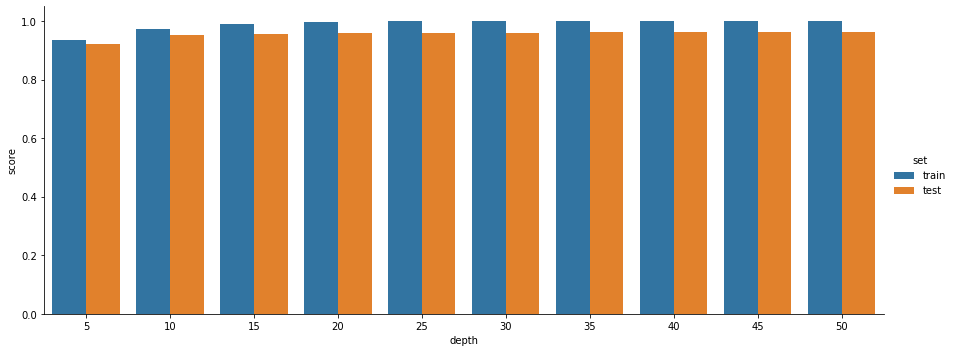

In [9]:
sns.catplot(x = 'depth', y = 'score', hue='set', data=results, kind = 'bar', aspect=2.5)

In [10]:
best_depth = depths[np.argsort(results.loc[(results['set'] == 'test')]['score'])[::-1]][0]
print('Best depth: {} with Test Accuracy = {:.4f}'.format(best_depth, 
                                                      np.array(results.loc[(results['set'] == 'test') & 
                                                                  (results['depth'] == best_depth)]['score'])[0]))
rfClf = RandomForestClassifier(max_depth=best_depth, random_state=0)
rfClf.fit(trainX, trainY)

Best depth: 50 with Test Accuracy = 0.9611


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

## K nearest neighbors

In [ ]:
ks = np.arange(1,51,4)
results = []

for k in tqdm(ks):
    knnClf = KNeighborsClassifier(n_neighbors=k)
    knnClf.fit(trainX.astype('float32'), trainY)
    trainPreds = knnClf.predict(trainX.astype('float32'))
    testPreds = knnClf.predict(testX.astype('float32'))

    results.append({'ks': k, 'set': 'train', 'score': accuracy_score(y_true=trainY, y_pred=trainPreds)})
    results.append({'ks': k, 'set': 'test', 'score': accuracy_score(y_true=testY, y_pred=testPreds)})
    
results = pd.DataFrame(results)

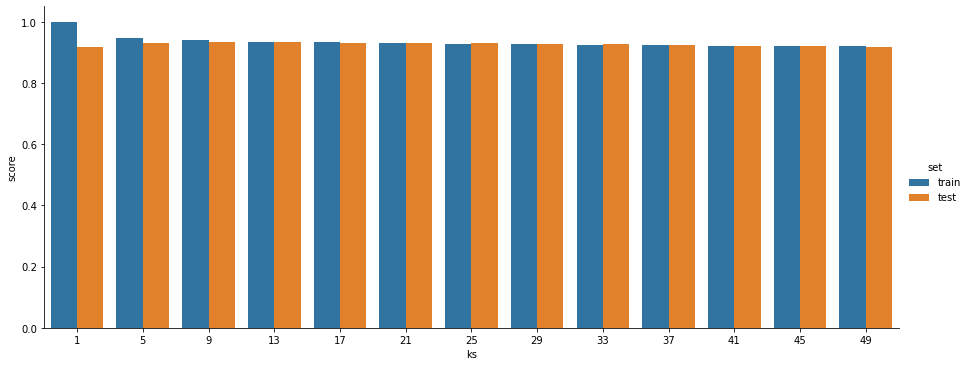

In [25]:
sns.catplot(x = 'ks', y = 'score', hue='set', data=results, kind = 'bar', aspect=2.5)

In [26]:
best_k = ks[np.argsort(results.loc[(results['set'] == 'test')]['score'])[::-1]][0]
print('Best depth: {} with Test Accuracy = {:.4f}'.format(best_depth, 
                                                      np.array(results.loc[(results['set'] == 'test') & 
                                                                  (results['ks'] == best_depth)]['score'])[0]))
knnClf = KNeighborsClassifier(n_neighbors=best_k)
knnClf.fit(trainX.astype('float32'), trainY)

Best depth: 25 with Test Accuracy = 0.9291


KNeighborsClassifier(n_neighbors=9)

## Smoothing with HMM

Two state Hidden Markov Model fitted on ordered dataset where observations are predicted by classifier from previous step and true hidden states are labeled data. HMM class is similar for every approach. Score method is looking at accuracy of model.

In [27]:
dataHTrain = pd.concat([pd.read_csv(REPO_DIR + "/data/data_{}.csv".format(i), index_col=False) for i in [1,2]])
dataHTrain.drop('Unnamed: 0', axis=1, inplace=True)
dataHTrain.drop('timestamp', axis=1, inplace=True)
dataHTest = pd.concat([pd.read_csv(REPO_DIR + "/data/data_{}.csv".format(i), index_col=False) for i in [3]])
dataHTest.drop('Unnamed: 0', axis=1, inplace=True)
dataHTest.drop('timestamp', axis=1, inplace=True)

In [28]:
trainHX = dataHTrain.drop('label', axis=1)
trainHY = dataHTrain['label']

testHX = dataHTest.drop('label', axis=1)
testHY = dataHTest['label']

In [29]:
class smoothHMM:

    def __init__(self, predictor, state_names):

        self.predictor = predictor
        self.modelHMM = HiddenMarkovModel()
        self.le=LabelEncoder()
        self.state_names = state_names

    def fit(self, X, y):
        
        X_simplified = self.le.fit_transform(self.predictor.predict(X)).reshape(1, -1)
        
        y = y.to_numpy().reshape(1, -1)

        self.modelHMM = self.modelHMM.from_samples(DiscreteDistribution, len(self.state_names), X_simplified, labels = y,
                                   algorithm='labeled', state_names=self.state_names , verbose = True)
        self.modelHMM.bake()
           

    def predict(self, X):

        X_simplified = self.le.transform(self.predictor.predict(X)).tolist()
        
        return self.modelHMM.predict(X_simplified)
    
    def score(self, X, y):
        
        target = self.predict(X)
        
        y = self.le.transform(y.to_numpy())
        
        return np.sum(target==y)/y.shape[0]

In [30]:
hmm = smoothHMM(knnClf, state_names=['music', 'speech'])
hmm.fit(trainHX, trainHY)
print('KNN ACCURACY AFTER SMOOTHING = {}'.format(hmm.score(testHX, testHY)))

[1] Improvement: 10167.535833673714	Time (s): 0.02505
[2] Improvement: 0.0	Time (s): 0.02692
Total Training Improvement: 10167.535833673714
Total Training Time (s): 0.0810
KNN ACCURACY AFTER SMOOTHING = 0.9423785947540293


In [31]:
hmm.modelHMM.states

[{
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "numpy.int64",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "0" : 0.9404567064141532,
                 "1" : 0.05954329358584678
             }
         ],
         "frozen" : false
     },
     "name" : "music",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "numpy.int64",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "0" : 0.06294267005211814,
                 "1" : 0.9370573299478818
             }
         ],
         "frozen" : false
     },
     "name" : "speech",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : null,
     "name" : "None-start",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : null,
     "name" : "None-end",
     "weight" : 1

In [32]:
hmm = smoothHMM(rfClf, state_names=['music', 'speech'])
hmm.fit(trainHX, trainHY)
hmm.score(testHX, testHY)
print('rfClf ACCURACY AFTER SMOOTHING = {}'.format(hmm.score(testHX, testHY)))

[1] Improvement: 12669.21600457796	Time (s): 0.02453
[2] Improvement: 0.0	Time (s): 0.02669
Total Training Improvement: 12669.21600457796
Total Training Time (s): 0.0765
rfClf ACCURACY AFTER SMOOTHING = 0.9958917096808174


In [33]:
hmm.modelHMM.states

[{
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "numpy.int64",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "0" : 0.9883095627776479,
                 "1" : 0.011690437222352116
             }
         ],
         "frozen" : false
     },
     "name" : "music",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "numpy.int64",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "0" : 0.015368167847120138,
                 "1" : 0.9846318321528799
             }
         ],
         "frozen" : false
     },
     "name" : "speech",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : null,
     "name" : "None-start",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : null,
     "name" : "None-end",
     "weight" :

# Learning & Evaluation - Unsupervised - Preprocessing 2

The following approach in our analysis is the joint algorithm of unsupervised method with supervised HMM smothing algorithm. The method in question is K-means and after research done it is suggested that Facebook's implementation of the classifier wins over Scikit-learn's, which will be verified. In this part of the project we work with data preprocessed having used 2nd method described earlier. Firstly we start by comparing the classifiers on complete dataframe (all features used). Secondly we perform Principal Component Analysis and choose the best number of them. Lastly smoothing with Hidden Markov Models in order to improve prediction accuracies of the classes attained by unsupervised method.

In [13]:
REPO_DIR = sys.path[0]+"/"

In [14]:
data = pd.concat([pd.read_csv(REPO_DIR + "/data/data_{}.csv".format(i), index_col=False) for i in [1,2]])
data.drop('Unnamed: 0', axis=1, inplace=True)
data.drop('timestamp', axis=1, inplace=True)

In [15]:
data.head(5)

,label,chroma_stft,rmse,spec_cent,spec_bw,rolloff,zcr,mfcc_0,mfcc_1,mfcc_2,...,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19
0,music,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-1131.370972,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,music,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-1131.370972,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,music,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-1131.370972,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,music,0.012444,0.081449,432.529692,424.989395,949.418501,0.01466,-632.946411,12.773681,-1.715082,...,-2.038454,-0.884550,-1.802255,0.243648,-0.727257,0.287844,0.141726,-0.364878,-0.763656,-0.566740
4,music,0.172535,0.435161,2309.434221,2392.904163,4963.403320,0.10235,-33.924923,96.108818,-15.746825,...,-10.182379,-11.484722,-13.531470,-5.707917,-9.890487,-1.513985,-8.121307,-4.673933,-4.060278,-2.206214


In [16]:
X = data.drop('label', axis=1)
y = data['label']

X_ = X.copy()
y_ = y.copy()

scaler = StandardScaler()
scaler.fit(X_)
X_ = scaler.transform(X_)
y_ = np.array(y_)

np.reshape(X_, X_.shape, order='C')
np.reshape(y_, y_.shape, order='C')

X_ = X_.astype('float32') # This X_ will be used to train classifiers a.k.a developments set, it is standarndized!!!

X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size = 0.3, random_state=42, shuffle=False)

In [74]:
class FaissKMeans:
    def __init__(self, n_clusters=8, n_redo=10, max_iter=300):
        self.n_clusters = n_clusters
        # redo means repeating with new starting points
        self.n_redo = n_redo
        self.max_iter = max_iter
        
        self.kmeans = None
        self.cluster_centers_ = None
        self.inertia_ = None
        self.cl_names = []

    def fit(self, X, y):
        self.kmeans = faiss.Kmeans(d=X.shape[1],
                                   k=self.n_clusters,
                                   niter=self.max_iter,
                                   nredo=self.n_redo)
        self.kmeans.train(X.astype(np.float32))
        self.cluster_centers_ = self.kmeans.centroids
        self.inertia_ = self.kmeans.obj[-1]
        
        preds = self.kmeans.index.search(X.astype(np.float32), 1)[1]
        
        for cl in range(self.n_clusters):
            self.cl_names.append(mode(y[preds.flatten()==cl])[0][0])
        

    def predict(self, X):
        preds = self.kmeans.index.search(X.astype(np.float32), 1)[1]
        preds = preds.reshape((X.shape[0], ))
        return np.array(pd.Series(preds).map({i: self.cl_names[i] for i in range(self.n_clusters)}))

In [92]:
class SklearnKMeans:
    def __init__(self, n_clusters=8, n_redo=10, max_iter=300, initialization='random'):
        self.n_clusters = n_clusters
        # redo means repeating with new starting points
        self.n_redo = n_redo
        self.max_iter = max_iter
        self.initialization = initialization
        self.cl_names = []
        
        self.kmeans = None
        self.cluster_centers_ = None
        

    def fit(self, X, y):
        self.kmeans = KMeans(n_clusters=self.n_clusters, 
                             random_state=0, 
                             init=self.initialization, 
                             n_init=self.n_redo, max_iter=self.max_iter)
        
        self.kmeans.fit(X)
        self.cluster_centers_ = self.kmeans.cluster_centers_
        
        preds = self.kmeans.predict(X)
        
        for cl in range(self.n_clusters):
            self.cl_names.append(mode(y[preds.flatten()==cl])[0][0])

    def predict(self, X):
        preds = self.kmeans.predict(X)
        preds = preds.reshape((X.shape[0], ))
        return np.array(pd.Series(preds).map({i: self.cl_names[i] for i in range(self.n_clusters)}))

In [82]:
K = 2

kmeansFaiss = FaissKMeans(n_clusters=K, max_iter=300, n_redo=50)
kmeansFaiss.fit(X_train, Y_train)
y_pred_faiss_train = kmeansFaiss.predict(X_train)
y_pred_faiss_test = kmeansFaiss.predict(X_test)

kmeansSklearn = SklearnKMeans(n_clusters=K, initialization='random', n_redo=50)
kmeansSklearn.fit(X_train, Y_train)
y_pred_sklearn_train = kmeansSklearn.predict(X_train)
y_pred_sklearn_test = kmeansSklearn.predict(X_test)

{0: 'speech', 1: 'music'}
{0: 'speech', 1: 'music'}


In [83]:
le = LabelEncoder()
trainAccuracies = {
    'sklearn': accuracy_score(y_true=Y_train, y_pred=y_pred_sklearn_train),
    'faiss': accuracy_score(y_true=Y_train, y_pred=y_pred_faiss_train)
}
trainAccuracies

{'sklearn': 0.8039300263599329, 'faiss': 0.8161035226455787}

In [84]:
testAccuracies = {
    'sklearn': accuracy_score(y_true=Y_test, y_pred=y_pred_sklearn_test),
    'faiss': accuracy_score(y_true=Y_test, y_pred=y_pred_faiss_test)
}
testAccuracies

{'sklearn': 0.7999552722799955, 'faiss': 0.8010734652801074}

## PCA

In [93]:
faiss_train_accuracies = []
sklearn_train_accuracies = []

faiss_test_accuracies = []
sklearn_test_accuracies = []

faiss_train_accuracies_dict = {}
sklearn_train_accuracies_dict = {}

faiss_test_accuracies_dict = {}
sklearn_test_accuracies_dict = {}

K = 2
n_features = data.shape[1]  # We have 26 features.
principal_components = np.arange(2, n_features, 1)

for principal_component in tqdm(principal_components):
    pca = PCA(n_components=principal_component)
    # use fit_transform to run PCA on our standardized matrix
    X_pcaed = pca.fit_transform(X_)
    trainX, testX, trainY, testY = train_test_split(
        X_pcaed, y_, test_size = 0.3, shuffle=False)
    
    kmeansFaiss = FaissKMeans(n_clusters=K, max_iter=300, n_redo=50)
    kmeansFaiss.fit(trainX, trainY)
    y_pred_faiss_train = kmeansFaiss.predict(trainX)
    y_pred_faiss_test = kmeansFaiss.predict(testX)
    
    curr_train_acc_faiss = accuracy_score(y_true=trainY, y_pred=y_pred_faiss_train)
    curr_test_acc_faiss = accuracy_score(y_true=testY, y_pred=y_pred_faiss_test)
    
    faiss_train_accuracies.append(curr_train_acc_faiss)
    faiss_test_accuracies.append(curr_test_acc_faiss)
    
    faiss_train_accuracies_dict[str(principal_component)] = curr_train_acc_faiss
    faiss_test_accuracies_dict[str(principal_component)] = curr_test_acc_faiss
    
    
    kmeansSklearn = SklearnKMeans(n_clusters=K, initialization='random', n_redo=50)
    kmeansSklearn.fit(trainX, trainY)
    y_pred_sklearn_train = kmeansSklearn.predict(trainX)
    y_pred_sklearn_test = kmeansSklearn.predict(testX)
    
    curr_train_acc = accuracy_score(y_true=trainY, y_pred=y_pred_sklearn_train)
    
    curr_test_acc = accuracy_score(y_true=testY, y_pred=y_pred_sklearn_test)
    
    sklearn_train_accuracies.append(curr_train_acc)
    sklearn_test_accuracies.append(curr_test_acc)
    
    sklearn_train_accuracies_dict[str(principal_component)] = curr_train_acc
    sklearn_test_accuracies_dict[str(principal_component)] = curr_test_acc

In [94]:
print('Faiss train accuracies:')
print(faiss_train_accuracies_dict)

Faiss train accuracies:
{'2': 0.7960220464893362, '3': 0.8080517613227893, '4': 0.8189312245387012, '5': 0.8222381979391326, '6': 0.8219027078840163, '7': 0.8221423436376707, '8': 0.8229091780493649, '9': 0.8223340522405943, '10': 0.8228133237479032, '11': 0.8227174694464414, '12': 0.821183800623053, '13': 0.8205128205128205, '14': 0.8238197939132519, '15': 0.8203690390606279, '16': 0.8114545890246825, '17': 0.8130841121495327, '18': 0.8120297148334531, '19': 0.8117900790797987, '20': 0.8162473040977714, '21': 0.8161035226455787, '22': 0.8158638868919242, '23': 0.8159597411933861, '24': 0.8159118140426551, '25': 0.8161035226455787, '26': 0.8161035226455787}


In [95]:
print('Faiss test accuracies:')
print(faiss_test_accuracies_dict)

Faiss test accuracies:
{'2': 0.7884378843788438, '3': 0.7987252599798725, '4': 0.8031980319803198, '5': 0.8004025494800403, '6': 0.8009616459800961, '7': 0.800849826680085, '8': 0.8012971038801298, '9': 0.8009616459800961, '10': 0.8017443810801744, '11': 0.8018562003801856, '12': 0.800849826680085, '13': 0.8007380073800738, '14': 0.8019680196801968, '15': 0.8011852845801185, '16': 0.7999552722799955, '17': 0.8004025494800403, '18': 0.7995079950799509, '19': 0.8000670915800067, '20': 0.8009616459800961, '21': 0.8010734652801074, '22': 0.8009616459800961, '23': 0.8009616459800961, '24': 0.8010734652801074, '25': 0.8010734652801074, '26': 0.8010734652801074}


In [96]:
print('Sklearn train accuracies:')
print(sklearn_train_accuracies_dict)

Sklearn train accuracies:
{'2': 0.7843757488617301, '3': 0.7945363048166787, '4': 0.7972202252576084, '5': 0.8007189072609633, '6': 0.8005751258087707, '7': 0.8002396357536544, '8': 0.8008147615624251, '9': 0.8007189072609633, '10': 0.8014378145219266, '11': 0.8018212317277738, '12': 0.8018691588785046, '13': 0.8018691588785046, '14': 0.8015815959741194, '15': 0.8015336688233885, '16': 0.8014857416726575, '17': 0.802588066139468, '18': 0.8028277018931225, '19': 0.8035466091540858, '20': 0.8037862449077402, '21': 0.8041217349628564, '22': 0.8039779535106638, '23': 0.8045530793194344, '24': 0.8045530793194344, '25': 0.8039300263599329, '26': 0.8039300263599329}


In [97]:
print('Sklearn test accuracies:')
print(sklearn_test_accuracies_dict)

Sklearn test accuracies:
{'2': 0.7907860896790786, '3': 0.8010734652801074, '4': 0.8017443810801744, '5': 0.7995079950799509, '6': 0.7997316336799731, '7': 0.799619814379962, '8': 0.7991725371799172, '9': 0.7991725371799172, '10': 0.7990607178799061, '11': 0.7991725371799172, '12': 0.7991725371799172, '13': 0.7991725371799172, '14': 0.7993961757799396, '15': 0.7991725371799172, '16': 0.7989488985798949, '17': 0.7998434529799844, '18': 0.7997316336799731, '19': 0.7998434529799844, '20': 0.7998434529799844, '21': 0.800290730180029, '22': 0.800290730180029, '23': 0.800290730180029, '24': 0.800290730180029, '25': 0.7999552722799955, '26': 0.7999552722799955}


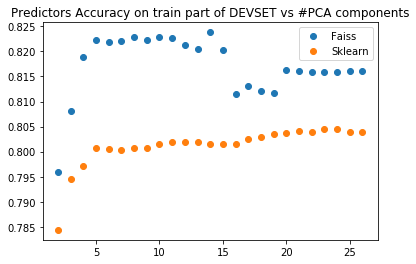

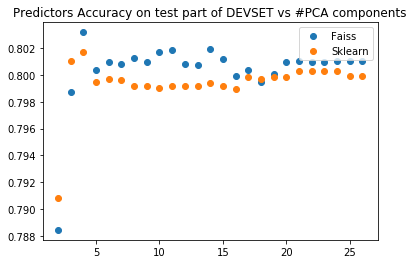

In [98]:
plt.plot(principal_components, faiss_train_accuracies, 'o')
plt.plot(principal_components, sklearn_train_accuracies, 'o')
plt.legend(['Faiss', 'Sklearn'])
plt.title('Predictors Accuracy on train part of DEVSET vs #PCA components')
plt.show()

plt.plot(principal_components, faiss_test_accuracies, 'o')
plt.plot(principal_components, sklearn_test_accuracies, 'o')
plt.legend(['Faiss', 'Sklearn'])
plt.title('Predictors Accuracy on test part of DEVSET vs #PCA components')
plt.show()

Observations:
Graphs present prediction accuracies on train and test parts of development set depending on number of principal components derived from our preprocessed, using 2nd method, data as descirbed at the beginning of this report. Both graphs compare accuracies' scores attained by both K-means classifiers (Faiss and Scikit-learn).
After short glimpse into the graphs one can clearly see that, as expected, in most of the cases Faiss library classifier reaches better results, Number of principal components resulting in best clssification score seem to be equal to 4.

In [100]:
num_components = 4
K = 2
pca = PCA(n_components=num_components)
# use fit_transform to run PCA on our standardized matrix
X_pcaed = pca.fit_transform(X_) 
#     print(X_pcaed.shape)
trainX, testX, trainY, testY = train_test_split(
    X_pcaed, y_, test_size = 0.3, shuffle=False)

kmeansFaiss = FaissKMeans(n_clusters=K, max_iter=300, n_redo=50)
kmeansFaiss.fit(trainX, trainY)
y_pred_faiss_train = kmeansFaiss.predict(trainX)
y_pred_faiss_test = kmeansFaiss.predict(testX)

kmeansSklearn = SklearnKMeans(n_clusters=K, initialization='random', n_redo=50)
kmeansSklearn.fit(trainX, trainY)
y_pred_sklearn_train = kmeansSklearn.predict(trainX)
y_pred_sklearn_test = kmeansSklearn.predict(testX)

In [111]:
class smoothHMM:

    def __init__(self, predictor, state_names, pca_n=4):

        self.predictor = predictor
        self.modelHMM = HiddenMarkovModel()
        self.le=LabelEncoder()
        self.state_names = state_names
        self.pca = PCA(n_components=pca_n)
        self.scaler = StandardScaler()

    def fit(self, X, y):
        
        X_ = X.copy()
        y_ = y.copy()

        self.scaler.fit(X_)
        X_ = self.scaler.transform(X_)
        y_ = np.array(y_)
              
        # use fit_transform to run PCA on our standardized matrix
        X_ = self.pca.fit_transform(X_)
        
        np.reshape(X_, X_.shape, order='C')
        np.reshape(y_, y_.shape, order='C')
        
        X_ = X_.astype('float32')
        X_simplified = self.le.fit_transform(self.predictor.predict(X_)).reshape(1, -1)
        y_simplified = y_.reshape(1, -1)
    
        self.modelHMM = self.modelHMM.from_samples(
            DiscreteDistribution, len(self.state_names), X_simplified, labels = y_simplified,
            algorithm='labeled', state_names=self.state_names , verbose = True)
        self.modelHMM.bake()
           

    def predict(self, X):
        
        X_ = X.copy()
        
        self.scaler.fit(X_)
        X_ = self.scaler.transform(X_)
              
        # use fit_transform to run PCA on our standardized matrix
        X_ = self.pca.fit_transform(X_)
        
        np.reshape(X_, X_.shape, order='C')
        
        X_ = X_.astype('float32')
            
        X_simplified = self.le.transform(self.predictor.predict(X_)).tolist()
        return self.modelHMM.predict(X_simplified)
    
    def score(self, X, y):
        
        target = self.predict(X)    
        y = self.le.transform(y.to_numpy())
        
        return np.sum(target==y)/y.shape[0]

## Test data load

In [ ]:
dataHTrain = pd.concat([pd.read_csv(REPO_DIR + "/data/data_{}.csv".format(i), index_col=False) for i in [1,2]])
dataHTrain.drop('Unnamed: 0', axis=1, inplace=True)
dataHTrain.drop('timestamp', axis=1, inplace=True)
dataHTest = pd.concat([pd.read_csv(REPO_DIR + "/data/data_{}.csv".format(i), index_col=False) for i in [3]])
dataHTest.drop('Unnamed: 0', axis=1, inplace=True)
dataHTest.drop('timestamp', axis=1, inplace=True)

## Performance tests on test sets

In [112]:
hmm_faiss = smoothHMM(kmeansFaiss, state_names=['music', 'speech'], pca_n=4)
hmm_faiss.fit(trainHX, trainHY)
print('Faiss library classifier score:', hmm_faiss.score(testHX, testHY))

[1] Improvement: 5469.0404691116655	Time (s): 0.01627
[2] Improvement: 0.0	Time (s): 0.01606
Total Training Improvement: 5469.0404691116655
Total Training Time (s): 0.0496
Faiss library classifier score: 0.8803328768566312


In [114]:
hmm.modelHMM.states

[{
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "numpy.int64",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "0" : 0.9885433715220949,
                 "1" : 0.011456628477905073
             }
         ],
         "frozen" : false
     },
     "name" : "music",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "numpy.int64",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "0" : 0.01550180408926901,
                 "1" : 0.984498195910731
             }
         ],
         "frozen" : false
     },
     "name" : "speech",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : null,
     "name" : "None-start",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : null,
     "name" : "None-end",
     "weight" : 1

In [113]:
hmm_sklearn = smoothHMM(kmeansSklearn, state_names=['music', 'speech'], pca_n=4)
hmm_sklearn.fit(trainHX, trainHY)
print('Sklearn library classifier score:', hmm_sklearn.score(testHX, testHY))

[1] Improvement: 5317.848837862015	Time (s): 0.01576
[2] Improvement: 0.0	Time (s): 0.01623
Total Training Improvement: 5317.848837862015
Total Training Time (s): 0.0485
Sklearn library classifier score: 0.8705361845570421


In [115]:
hmm.modelHMM.states

[{
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "numpy.int64",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "0" : 0.9885433715220949,
                 "1" : 0.011456628477905073
             }
         ],
         "frozen" : false
     },
     "name" : "music",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "numpy.int64",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "0" : 0.01550180408926901,
                 "1" : 0.984498195910731
             }
         ],
         "frozen" : false
     },
     "name" : "speech",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : null,
     "name" : "None-start",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : null,
     "name" : "None-end",
     "weight" : 1

Observations:
Lastly we can conclude that all of all unsupervised method with HMM smothing did quite well and as expected slightly better performance is attained using Faiss implementation of K-means classifier reaching predition accuracy at level of 88%, which is an improvement of 7% attained after applying HMM smoothing.